In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import interp1d
import seaborn as sns
 
sns.set_style("whitegrid")

c:\Users\leonardo.simoes\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## FUNÇÕES

#### Função para calcular a eólica

In [3]:
def calculo_eolica(a, w, usina):
    # Definir o valor equivalente a densidade do ar
    d_ar = 1.225
    # Listas para armazenar os valores de geração e cp 
    geracao = []
    cp_list = []
    # Transformar os valores do dataframe de vento de entrada em lista, para facilitar o manuseio
    list_wind = list(w)

    # Loop para percorrer os valores da lista de dados de vento
    for wind in list_wind:
        # Definição das equações de CP dos aerogeradores Gamesa G97 e Enercon E92
        # Dados obtidos do site Wind Turbine Models
        cp_gamesa = (0.00000000008408467587 * pow(wind, 10)) - (0.00000001150867100853 * pow(wind, 9)) + (0.00000067953030629860 * pow(wind, 8)) - (0.00002266717700213885 * pow(wind, 7)) + (0.00047019516194872431 * pow(wind, 6)) - (0.00629862498494437786 * pow(wind, 5)) + (0.05483891580627969775 * pow(wind, 4)) - (0.30347884901308558314 * pow(wind, 3)) + (0.98948798201540932862 * pow(wind, 2)) - (1.51974980198908915519 * wind) + 0.79021774
        cp_enercon = (0.00000000011306605368 * pow(wind, 10)) - (0.00000001532490019587 * pow(wind, 9)) + (0.00000089325408546230 * pow(wind, 8)) - (0.00002925938664317823 * pow(wind, 7)) + (0.00059072251319006142 * pow(wind, 6)) - (0.00758801074166572369 * pow(wind, 5)) + (0.06184540783583986068 * pow(wind, 4)) - (0.30912179494821595549 * pow(wind, 3)) + (0.86787073094083799774 * pow(wind, 2)) - (1.05823468949424226437 * wind) + 0.44696046
        # Para o Goldwind, foram utilizados os dados do AEG18 para diretamente definir a geração por meio da velocidade do vento
        geracao_goldwind = (- 0.39826470) + (1.12204055891863974104 * wind) - (1.22828550737722119734 * pow(wind, 2)) + (0.69436437893823754752 * pow(wind, 3)) - (0.22818968172817086226 * pow(wind, 4)) + (0.04670208517989218877 * pow(wind, 5)) - (0.00610575515790191987 * pow(wind, 6)) + (0.00050963055538820283 * pow(wind, 7)) - (0.00002623439189743304 * pow(wind, 8)) + (0.00000075646640774112 * pow(wind, 9)) - (0.00000000930294642830 * pow(wind, 10))
        # Condicional para direcionar o cálculo da geração eólica para cada caso, considerando os modelos de aerogeradores
        if usina == 'gamesa':
            # Atribuição do valor do cp específico à variável geral
            cp = cp_gamesa
            # Atribuição dos valores de eólica a zero, caso a velocidade de vento esteja abaixo do mínimo especificado pelo fabricante
            if wind <= 2: eol = 0
            else:
                # Cálculo da geração, com base na formulação da equação cúbica  
                eol = abs((0.5 * d_ar * a * (wind ** 3) * cp) / 1000000)
                # Saturação dos valores de geração que se encontrarem acima do valor máximo
                if eol >= 2 or wind >= 11.5: eol = 2
                else: pass
            cp_list.append(cp)
        # Condicional para direcionar o cálculo da geração eólica para cada caso, considerando os modelos de aerogeradores
        elif usina == 'enercon':
            # Atribuição do valor do cp específico à variável geral
            cp = cp_enercon
            # Atribuição dos valores de eólica a zero, caso a velocidade de vento esteja abaixo do mínimo especificado pelo fabricante
            if wind <= 1: eol = 0
            else:
                # Cálculo da geração, com base na formulação da equação cúbica
                eol = abs((0.5 * d_ar * a * (wind ** 3) * cp) / 1000000)
                # Saturação dos valores de geração que se encontrarem acima do valor máximo
                if eol >= 2.35 or wind >= 14: eol = 2.35
                else: pass
            cp_list.append(cp)
        # Condicional para direcionar o cálculo da geração eólica para cada caso, considerando os modelos de aerogeradores
        elif usina == 'goldwind':
            # Atribuição direta do valor de geração específico à variável geral
            eol = geracao_goldwind
            # Atribuição dos valores de eólica a zero, caso a velocidade de vento esteja abaixo do mínimo especificado pelo fabricante
            if wind <= 2.5: eol = 0
            # Saturação dos valores de geração que se encontrarem acima do valor máximo
            elif eol >= 1.5 or wind >= 11: eol = 1.5
            else: pass
        else: pass

        # Armazenamento dos valores de cp e de geração na lista
        geracao.append(eol)
    
    # Retorno dos valores para a variável a qual a função foi atribuída
    return geracao, cp_list

#### Regressão Polinomial

In [13]:
def reg_polinomial (x, y, grau, scatter_label, xlabel, ylabel):
    
    # Criação do objeto polinomial
    carac_reg = PolynomialFeatures(degree=grau)
    # Transposição do x (de linha em coluna)
    x = x.reshape(-1, 1)
    # Aplicação do fit na variável x
    x_reg = carac_reg.fit_transform(x)

    # Criação do modelo de regressão linear
    model_reg = LinearRegression()
    # Aplicação das múltiplas regressões lineares de acordo com o grau do polinômio
    model_reg.fit(x_reg, y)
    # Adequação do y ao valor previsto pelo modelo
    y_reg = model_reg.predict(x_reg)

    # Configuração e execução do plot de dispersão
    plt.scatter(x, y, label=scatter_label)
    plt.plot(x, y_reg, color='red', label='Regressão')
    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.xlabel(xlabel=xlabel, fontweight='bold', fontsize=15)
    plt.ylabel(ylabel=ylabel, fontweight='bold', fontsize=15)
    plt.legend()

    # Variável para extrair os coeficientes do modelo de regressão polinomial
    coeficientes = model_reg.coef_
    # Variável para extrair o termo constante do modelo de regressão polinomial
    termo_constante = model_reg.intercept_

    # Lógica para montar a equação em uma string, concatenando os valores dos coeficientes obtidos acima
    equacao = f'Cp = {termo_constante:.8f} + '
    for i, coeficiente in enumerate(coeficientes[1:]):
        equacao += f'{coeficiente:.20f} * x^{i+1} + '
    print('\nEquação do modelo:')
    print(equacao[:-2])

    return x_reg, y_reg

#### Cálculo do erro

In [5]:
def calculo_erro(y, y_reg):
    # Erro absoluto médio
    erro_abs = mean_absolute_error(y, y_reg)
    # Raiz do erro quadrático médio
    erro_quad = np.sqrt(mean_squared_error(y, y_reg))
    
    return erro_abs, erro_quad

## GAMESA G97 - PINDAÍ

#### Aquisição de dados de CP

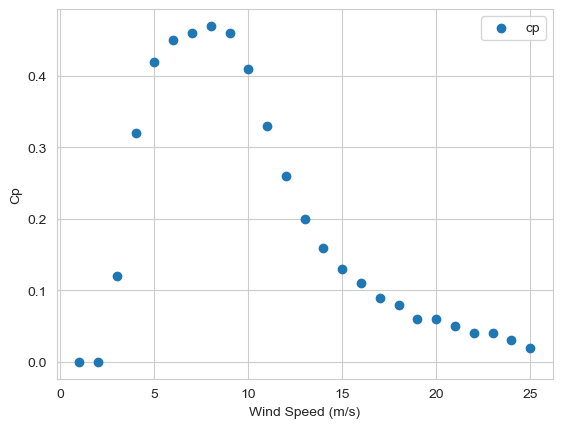

In [19]:
# Coleta dos dados obtidos de: https://en.wind-turbine-models.com/turbines/764-gamesa-g97
pindai_cp = {
    'Wind Speed': range(1, 26),
    'cp': (0, 0, 0.12, 0.32, 0.42, 0.45, 0.46, 0.47, 0.46, 0.41, 0.33, 0.26, 0.20, 0.16, 0.13, 0.11, 0.09, 0.08, 0.06, 0.06, 0.05, 0.04, 0.04, 0.03, 0.02)
}

# Transformação do dicionário em dataframe pandas
pindai_cp_df = pd.DataFrame.from_dict(pindai_cp)

# Configuração e execução do plot de dispersão
plt.scatter(pindai_cp_df['Wind Speed'].values, pindai_cp_df['cp'].values, label='cp')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Cp')
plt.legend()

#### Execução da regressão polinomial


Equação do modelo:
Cp = 0.79021774 + -1.51974980198908915519 * x^1 + 0.98948798201540932862 * x^2 + -0.30347884901308558314 * x^3 + 0.05483891580627969775 * x^4 + -0.00629862498494437786 * x^5 + 0.00047019516194872431 * x^6 + -0.00002266717700213885 * x^7 + 0.00000067953030629860 * x^8 + -0.00000001150867100853 * x^9 + 0.00000000008408467587 * x^10 

Erro absoluto: 0.00795147838328371, Erro quadrático: 0.010524160676087213


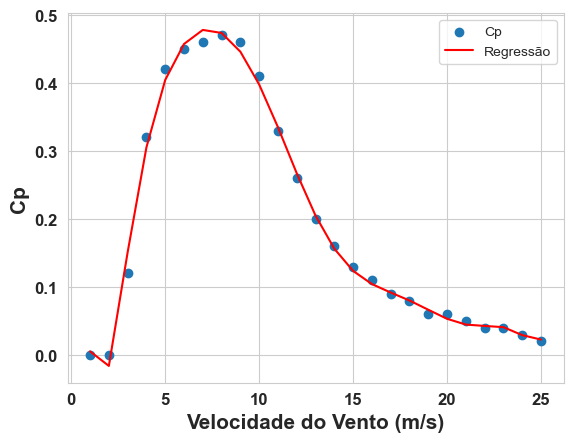

In [20]:
# Execução da função de regressão polinomial
x_reg, y_reg = reg_polinomial(x=pindai_cp_df['Wind Speed'].values, y=pindai_cp_df['cp'].values, grau=10, scatter_label='Cp', xlabel='Velocidade do Vento (m/s)', ylabel='Cp')

# Execução da função de erro
erro_abs, erro_quad = calculo_erro(y=pindai_cp_df['cp'].values, y_reg=y_reg)

print(f'\nErro absoluto: {erro_abs}, Erro quadrático: {erro_quad}')

#### Aquisição de dados de vento

In [21]:
# Leitura do arquivo que consta as datas
data = pd.read_csv('data.csv')
# Área da seção do rotor da turbina Gamesa G97
a_pindai = 7390

# Leitura do arquivo csv de tmy de vento da região de Pindaí
# Corrigir depois os dados anuais da NASA para o padrão TMY 
tmy_pindai = pd.read_csv("tmy pindaí.csv", sep=';')
# Excluindo valores faltantes
tmy_pindai = tmy_pindai.dropna()
# Excluindo colunas desnecessarias
tmy_pindai = tmy_pindai.drop(['Year', 'Day', 'Month', 'Hour', 'Minute'], axis=1)
# Inserindo a coluna de data no padrão correto
tmy_pindai.insert(loc=len(tmy_pindai.columns), column='Data', value=data["Data"])
# Organização da ordem das colunas
tmy_pindai = tmy_pindai[['Data', 'Wind Speed']]

# Aplicação da função de cálculo da eólica
gamesa, cp = calculo_eolica(a=a_pindai, w=list(tmy_pindai['Wind Speed']), usina='gamesa')
# Atribuição dos valores de geração calculados pela função para a coluna de geração do tmy
tmy_pindai["Geração"] = gamesa

tmy_pindai

,Data,Wind Speed,Geração
0,2023-01-01 00:30:00,8.109638,1.138943
1,2023-01-01 01:30:00,8.098982,1.134936
2,2023-01-01 02:30:00,7.992416,1.094975
3,2023-01-01 03:30:00,7.811255,1.027637
4,2023-01-01 04:30:00,7.885850,1.055258
...,...,...,...
8755,2023-12-31 19:30:00,0.500858,0.000000
8756,2023-12-31 20:30:00,1.236160,0.000000
8757,2023-12-31 21:30:00,1.470605,0.000000
8758,2023-12-31 22:30:00,0.447575,0.000000


#### Cálculo das Usinas de Pindaí

In [22]:
# Criação de dicionário com o nome da usina e o número de aerogeradores utilizados
usinas_pindai = {
    'Acaua': 3,
    'Angical II': 5,
    'Arapapa': 2,
    'Caititu II': 5,
    'Caititu III': 5,
    'Carcara': 5,
    'Coqueirinho II': 8,
    'Corrupião III': 5,
    'Papagaio': 5,
    'Tamandua Mirim II': 8,
    'Teiu II': 4
    }

# Criação de dicionário para exportação dos valores das usinas
geracao_pindai = {}

# Loop para percorrer cada uma das usinas do dicionário dos aerogeradores
for usina, mult in usinas_pindai.items():
    # Criar uma cópia do tmy_pindai e atribuir a usina referente do dicionário de usinas
    globals()[usina] = tmy_pindai.copy()
    # Multiplicar a geração do aerogerador pelo numero de aerogeradores, a fim de obter a geração total do parque
    globals()[usina]['Geração'] = tmy_pindai['Geração'] * mult
    #globals()[usina] = globals()[usina][['Data', 'Wind Speed', 'Geração']]
    # Exportar cada uma das usinas para um csv nomeado de acordo com o nome descrito no dicionário
    globals()[usina].to_csv(f'{usina}.csv', index='False')

#### Comparação da curva Vento x Potência

0.012116435045674572 0.014726403217488937


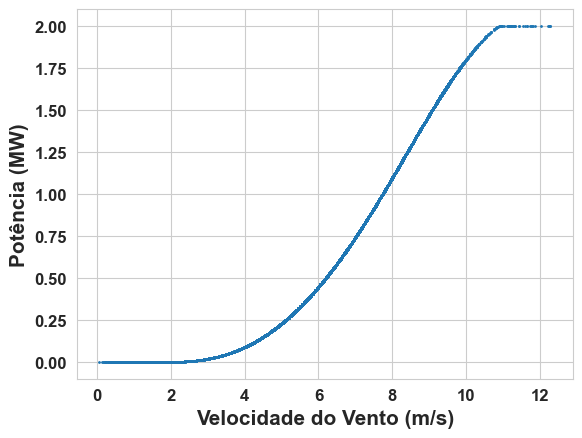

In [23]:
# Aquisição dos dados de curva vento x potência do aerogerador: https://en.wind-turbine-models.com/turbines/764-gamesa-g97
curva_pindai = [0, 0, 0, 0.014, 0.094, 0.236, 0.438, 0.714, 1.084, 1.508, 1.836, 1.973, 1.992, 1.998, 2, 2, 2]
w = range(0, 17)

# Configuração e execução do plot de dispersão
plt.scatter(tmy_pindai['Wind Speed'], tmy_pindai['Geração'], s=1)
#plt.plot(w, curva_pindai, color = 'red')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Velocidade do Vento (m/s)', fontweight='bold', fontsize=15)
plt.ylabel('Potência (MW)', fontweight='bold', fontsize=15)

# Interpolar a curva de vento x potência, com o intuito de padronizar o número de pontos para cada gráfico
curva_interpolada = interp1d(w, curva_pindai, kind='linear', fill_value='extrapolate')
curva_interpolada_y = curva_interpolada(tmy_pindai['Wind Speed'])

# Cálculo de erro médio absoluto e erro médio quadrático
erro_abs = mean_absolute_error(tmy_pindai['Geração'], curva_interpolada_y)
erro_quad = np.sqrt(mean_squared_error(tmy_pindai['Geração'], curva_interpolada_y))

print(erro_abs, erro_quad)

## ENERCON E92 - CASA NOVA II E III

#### Aquisição de dados de CP

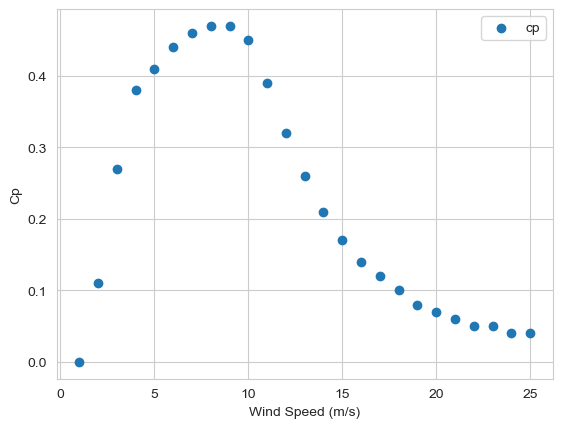

In [9]:
# Coleta dos dados obtidos de: https://en.wind-turbine-models.com/turbines/131-enercon-e-92
enercon_cp = {
    'Wind Speed': range(1, 26),
    'cp': (0, 0.11, 0.27, 0.38, 0.41, 0.44, 0.46, 0.47, 0.47, 0.45, 0.39, 0.32, 0.26, 0.21, 0.17, 0.14, 0.12, 0.10, 0.08, 0.07, 0.06, 0.05, 0.05, 0.04, 0.04)
}

# Transformação do dicionário em dataframe pandas
enercon_cp_df = pd.DataFrame.from_dict(enercon_cp)

# Configuração e execução do plot de dispersão
plt.scatter(enercon_cp_df['Wind Speed'].values, enercon_cp_df['cp'].values, label='cp')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Cp')
plt.legend()

#### Execução da regressão polinomial


Equação do modelo:
Cp = 0.44696046 + -1.05823468949424226437 * x^1 + 0.86787073094083799774 * x^2 + -0.30912179494821595549 * x^3 + 0.06184540783583986068 * x^4 + -0.00758801074166572369 * x^5 + 0.00059072251319006142 * x^6 + -0.00002925938664317823 * x^7 + 0.00000089325408546230 * x^8 + -0.00000001532490019587 * x^9 + 0.00000000011306605368 * x^10 

Erro absoluto: 0.003105051041667027, Erro quadrático: 0.003915163892148946


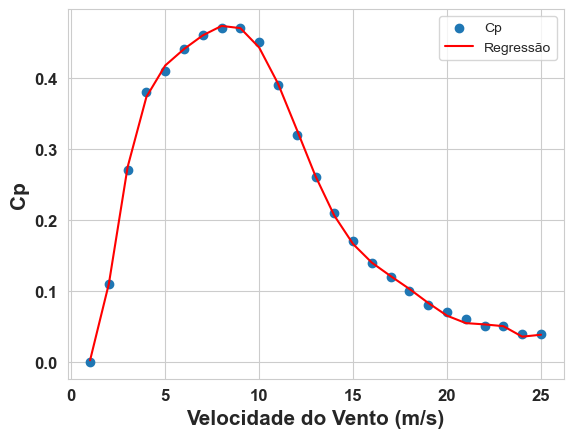

In [14]:
# Execução da função de regressão polinomial
x_reg, y_reg = reg_polinomial(x=enercon_cp_df['Wind Speed'].values, y=enercon_cp_df['cp'].values, grau=10, scatter_label='Cp', xlabel='Velocidade do Vento (m/s)', ylabel='Cp')

# Execução da função de erro
erro_abs, erro_quad = calculo_erro(y=enercon_cp_df['cp'].values, y_reg=y_reg)

print(f'\nErro absoluto: {erro_abs}, Erro quadrático: {erro_quad}')

#### Aquisição de dados de vento

In [15]:
# Leitura do arquivo que consta as datas
data = pd.read_csv('data.csv')
# Área da seção do rotor da turbina Enercon E92
a_enercon = 6648

# Leitura do arquivo csv de tmy de vento da região de Casa Nova
# Corrigir depois os dados anuais da NASA para o padrão TMY 
tmy_enercon = pd.read_csv("tmy casa nova.csv", sep=';')
# Excluindo valores faltantes
tmy_enercon = tmy_enercon.dropna()
# Excluindo colunas desnecessarias
tmy_enercon = tmy_enercon.drop(['Year', 'Day', 'Month', 'Hour', 'Minute'], axis=1)
# Inserindo a coluna de data no padrão correto
tmy_enercon.insert(loc=len(tmy_enercon.columns), column='Data', value=data["Data"])
# Organização da ordem das colunas
tmy_enercon = tmy_enercon[['Data', 'Wind Speed']]

# Aplicação da função de cálculo da eólica
enercon, cp = calculo_eolica(a=a_enercon, w=list(tmy_enercon['Wind Speed']), usina='enercon')
# Atribuição dos valores de geração calculados pela função para a coluna de geração do tmy
tmy_enercon["Geração"] = enercon

tmy_enercon

,Data,Wind Speed,Geração
0,2023-01-01 00:30:00,9.708121,1.688866
1,2023-01-01 01:30:00,9.090041,1.433142
2,2023-01-01 02:30:00,8.972819,1.383699
3,2023-01-01 03:30:00,8.876910,1.343267
4,2023-01-01 04:30:00,8.653122,1.249430
...,...,...,...
8755,2023-12-31 19:30:00,5.466813,0.285589
8756,2023-12-31 20:30:00,5.647974,0.317864
8757,2023-12-31 21:30:00,5.871762,0.361033
8758,2023-12-31 22:30:00,5.925044,0.371875


#### Cálculo das Usinas de Casa Nova II e III

In [16]:
# Criação de dicionário com o nome da usina e o número de aerogeradores utilizados
usinas_enercon = {
    'Casa Nova II': 14,
    'Casa Nova III': 12,
    }

# Criação de dicionário para exportação dos valores das usinas
geracao_pindai = {}

# Loop para percorrer cada uma das usinas do dicionário dos aerogeradores
for usina, mult in usinas_enercon.items():
    # Criar uma cópia do tmy_pindai e atribuir a usina referente do dicionário de usinas
    globals()[usina] = tmy_enercon.copy()
    # Multiplicar a geração do aerogerador pelo numero de aerogeradores, a fim de obter a geração total do parque
    globals()[usina]['Geração'] = tmy_enercon['Geração'] * mult
    #globals()[usina] = globals()[usina][['Data', 'Wind Speed', 'Geração']]
    # Exportar cada uma das usinas para um csv nomeado de acordo com o nome descrito no dicionário
    globals()[usina].to_csv(f'{usina}.csv', index='False')

#### Comparação da curva Vento x Potência

Text(0, 0.5, 'Potência (MW)')

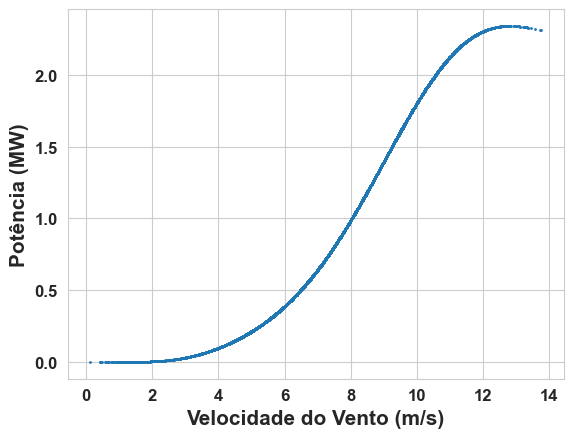

In [18]:
# Aquisição dos dados de curva vento x potência do aerogerador: https://en.wind-turbine-models.com/turbines/131-enercon-e-92
curva_enercon = [0, 0, 0.0036, 0.0299, 0.0982, 0.2083, 0.3843, 0.6370, 0.9758, 1.4036, 1.8178, 2.0887, 2.2370, 2.300, 2.350, 2.350, 2.350]
w = range(0, 17)

tmy_enercon_plot = tmy_enercon.copy()
tmy_enercon_plot = tmy_enercon_plot[tmy_enercon_plot['Wind Speed'] < 14]

# Configuração e execução do plot de dispersão
plt.scatter(tmy_enercon_plot['Wind Speed'], tmy_enercon_plot['Geração'], s=1)
#plt.plot(w, curva_enercon, color = 'red')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Velocidade do Vento (m/s)', fontweight='bold', fontsize=15)
plt.ylabel('Potência (MW)', fontweight='bold', fontsize=15)

## GOLDWIND GW82 - CASA NOVA A

### Fit Dados AEG18

#### Aquisição dos dados de geração

,Vento (m/s),Geração (MW)
0,9.051667,1.020112
1,10.195000,1.277857
2,9.761667,1.188200
3,9.515000,1.094753
4,9.921667,1.206923
...,...,...
8692,1.321667,0.000000
8693,1.610000,0.000000
8694,2.746667,0.000000
8695,2.790000,0.000000


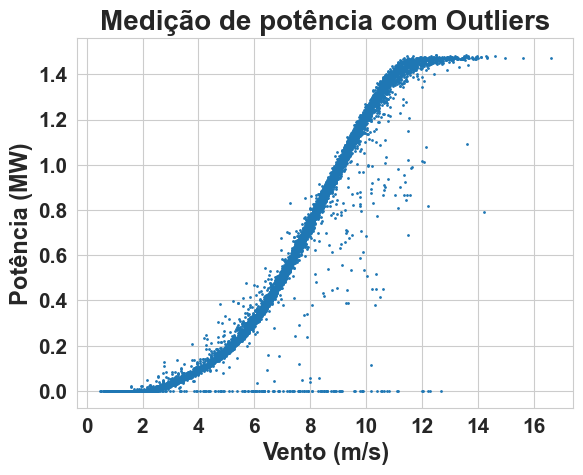

In [18]:
# Importação dos dados de geração do AEG 18
cna_model = pd.read_excel("dados aeg18.xlsx")
# Exclusão da coluna de data
cna_model = cna_model.drop('Data', axis=1)
# Excluindo valores faltantes
cna_model = cna_model.dropna()
# Ajuste de indexação
cna_model = cna_model.reset_index(drop=True)
# Zerar valores negativos
cna_model = cna_model.map(lambda x: max(x, 0))

# Conversão de kilo em mega
cna_model['Geração (MW)'] = cna_model['Geração (MW)'] /1000

# Configuração e execução do plot de dispersão
plt.figure()
plt.title('Medição de potência com Outliers', fontsize=20, fontweight='bold')
plt.scatter(cna_model['Vento (m/s)'].values, cna_model['Geração (MW)'].values, s=1)
plt.xlabel('Vento (m/s)', fontsize=17, fontweight='bold')
plt.ylabel('Potência (MW)', fontsize=17, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=15)
plt.yticks(fontweight='bold', fontsize=15)
plt.savefig(f'scatter aeg18.png', dpi=1000, bbox_inches='tight')
cna_model

#### Remoção de outliers

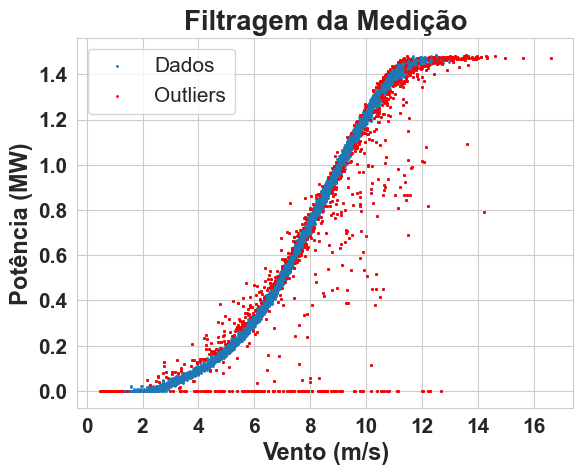

In [15]:
# Uso da bibloteca Pyod: 
from pyod.models.knn import KNN

# Criação do objeto KNN
detector = KNN()
# Aplicação do modelo de fit no modelo de Casa Nova A
detector.fit(cna_model)
# Armazenar as previsões de outliers na variável
previsoes = detector.labels_

# Armazenamento das previsões de outliers 
outliers = [i for i, label in enumerate(previsoes) if label == 1]

# Inserir os outliers na lista
for i in range(len(previsoes)):
    if previsoes[i] == 1:
        outliers.append(i)

# Pegar apenas os outliers do modelo de Casa Nova A
lista_outliers = cna_model.iloc[outliers,:]

# Plot dos dois gráficos de dispersão, da curva e dos outliers
plt.figure()
plt.scatter(cna_model['Vento (m/s)'], cna_model['Geração (MW)'], s=1)
plt.scatter(lista_outliers['Vento (m/s)'], lista_outliers['Geração (MW)'], color='red', s=1)
#plt.plot(x, y_reg, color='gold', linewidth=0.01)
plt.xlabel('Vento (m/s)', fontsize=17, fontweight='bold')
plt.ylabel('Potência (MW)', fontsize=17, fontweight='bold')
plt.title('Filtragem da Medição', fontsize=20, fontweight='bold')
plt.legend(['Dados', 'Outliers', 'Regressão'], fontsize=15)
plt.xticks(fontweight='bold', fontsize=15)
plt.yticks(fontweight='bold', fontsize=15)
plt.savefig(f'scatter aeg18 regressao.png', dpi=1000, bbox_inches='tight')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4'),
  Text(0, 1.6, '1.6')])

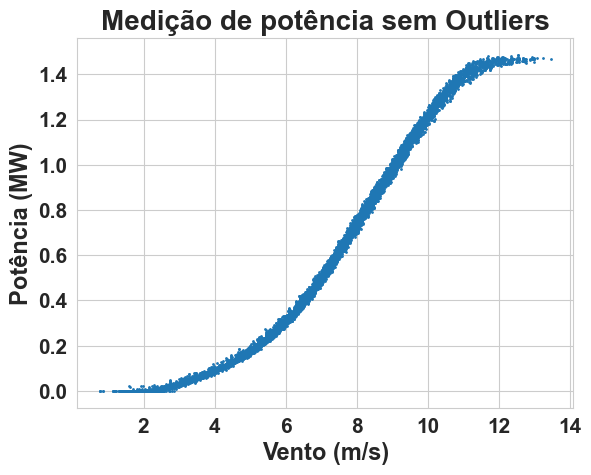

In [20]:
# Remover os outliers do modelode Casa Nova A
cna_model_pyod = cna_model.drop(outliers)

# Plot do gráfico de dispersão sem os outliers
plt.figure()
plt.scatter(cna_model_pyod['Vento (m/s)'], cna_model_pyod['Geração (MW)'], label='Data', s=1)
plt.xlabel('Vento (m/s)', fontsize=17, fontweight='bold')
plt.ylabel('Potência (MW)', fontsize=17, fontweight='bold')
plt.title('Medição de potência sem Outliers', fontsize=20, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=15)
plt.yticks(fontweight='bold', fontsize=15)

#### Regressão Polinomial do scatter sem outliers

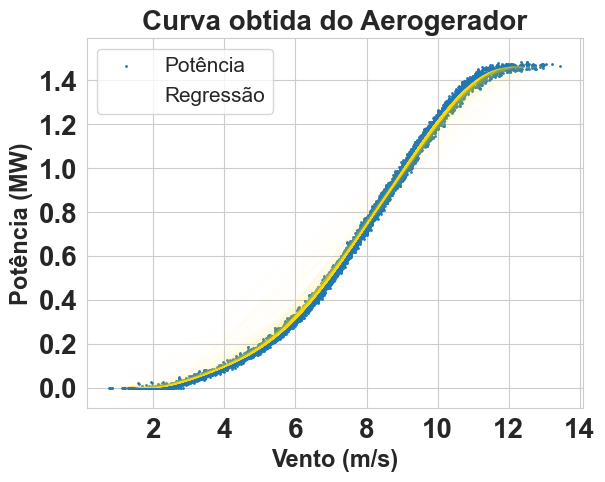

In [22]:
x = cna_model_pyod['Vento (m/s)'].values
y = cna_model_pyod['Geração (MW)'].values

grau = 10

carac_reg = PolynomialFeatures(degree=grau)
x = x.reshape(-1, 1)
x_reg = carac_reg.fit_transform(x)

model_reg = LinearRegression()
model_reg.fit(x_reg, y)
y_reg = model_reg.predict(x_reg)

plt.figure()
plt.scatter(x, y, label='Potência', s=1)
plt.plot(x, y_reg, color='gold', label='Regressão', linewidth=0.01)
plt.xlabel('Vento (m/s)', fontsize=17, fontweight='bold')
plt.ylabel('Potência (MW)', fontsize=17, fontweight='bold')
plt.title('Curva obtida do Aerogerador', fontsize=20, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=20)
plt.yticks(fontweight='bold', fontsize=20)
plt.legend(['Potência', 'Regressão'], fontsize=15)


In [438]:
erro_abs = mean_absolute_error(y, y_reg)
erro_quad = np.sqrt(mean_squared_error(y, y_reg))

print(erro_abs, erro_quad)

0.012226519881782348 0.016184882339891533


In [439]:
coeficientes = model_reg.coef_
termo_constante = model_reg.intercept_

# Exibindo a equação
equacao = f'Geração = {termo_constante:.8f} + '
for i, coeficiente in enumerate(coeficientes[1:]):
    equacao += f'{coeficiente:.20f} * x^{i+1} + '

print('\nEquação do modelo:')
print(equacao[:-2]) 


Equação do modelo:
Geração = -0.39826470 + 1.12204055891863974104 * x^1 + -1.22828550737722119734 * x^2 + 0.69436437893823754752 * x^3 + -0.22818968172817086226 * x^4 + 0.04670208517989218877 * x^5 + -0.00610575515790191987 * x^6 + 0.00050963055538820283 * x^7 + -0.00002623439189743304 * x^8 + 0.00000075646640774112 * x^9 + -0.00000000930294642830 * x^10 


#### Teste da função de 10ª ordem gerada pela regressão

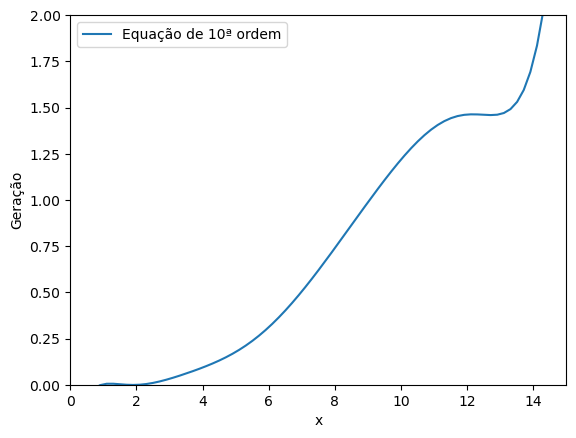

In [361]:
# Definição da equação dentro de uma função
def equacao_10_ordem(x):
    return (-0.39826470 +
            1.12204055891863974104 * x**1 +
            -1.22828550737722119734 * x**2 +
            0.69436437893823754752 * x**3 +
            -0.22818968172817086226 * x**4 +
            0.04670208517989218877 * x**5 +
            -0.00610575515790191987 * x**6 +
            0.00050963055538820283 * x**7 +
            -0.00002623439189743304 * x**8 +
            0.00000075646640774112 * x**9 +
            -0.00000000930294642830 * x**10)

# Gere valores de x para o gráfico
x_values = np.linspace(-100, 100, 1000)

# Avalie a função para cada valor de x
y_values = equacao_10_ordem(x_values)

# Plote o gráfico
plt.plot(x_values, y_values, label='Equação de 10ª ordem')
plt.xlabel('x')
plt.xlim(0,15)
plt.ylim(0,2)
plt.ylabel('Geração')
plt.legend()

### Cálculo da geração eólica anual

In [447]:
# Leitura do arquivo que consta as datas
data = pd.read_csv('data.csv')
# Área da seção do rotor da turbina Enercon E92
a_goldwind = 5325

# Leitura do arquivo csv de tmy de vento da região de Casa Nova
# Corrigir depois os dados anuais da NASA para o padrão TMY 
tmy_goldwind = pd.read_csv("tmy casa nova.csv", sep=';')
# Excluindo valores faltantes
tmy_goldwind = tmy_goldwind.dropna()
# Excluindo colunas desnecessarias
tmy_goldwind = tmy_goldwind.drop(['Year', 'Day', 'Month', 'Hour', 'Minute'], axis=1)
# Inserindo a coluna de data no padrão correto
tmy_goldwind.insert(loc=len(tmy_goldwind.columns), column='Data', value=data["Data"])
# Organização da ordem das colunas
tmy_goldwind = tmy_goldwind[['Data', 'Wind Speed']]

# Aplicação da função de cálculo da eólica
goldwind, cp = calculo_eolica(a=a_goldwind, w=list(tmy_goldwind['Wind Speed']), usina='goldwind')
# Atribuição dos valores de geração calculados pela função para a coluna de geração do tmy
tmy_goldwind["Geração"] = goldwind

tmy_goldwind

,Data,Wind Speed,Geração
0,2023-01-01 00:30:00,9.708121,1.154098
1,2023-01-01 01:30:00,9.090041,1.008682
2,2023-01-01 02:30:00,8.972819,0.980067
3,2023-01-01 03:30:00,8.876910,0.956504
4,2023-01-01 04:30:00,8.653122,0.901148
...,...,...,...
8755,2023-12-31 19:30:00,5.466813,0.232089
8756,2023-12-31 20:30:00,5.647974,0.256919
8757,2023-12-31 21:30:00,5.871762,0.290423
8758,2023-12-31 22:30:00,5.925044,0.298865


In [ ]:
usinas_cna = {
    'Casa Nova A': 18
    }

# Criação de dicionário para exportação dos valores das usinas
geracao_cna = {}

# Loop para percorrer cada uma das usinas do dicionário dos aerogeradores
for usina, mult in usinas_cna.items():
    # Criar uma cópia do tmy_pindai e atribuir a usina referente do dicionário de usinas
    globals()[usina] = tmy_goldwind.copy()
    # Multiplicar a geração do aerogerador pelo numero de aerogeradores, a fim de obter a geração total do parque
    globals()[usina]['Geração'] = tmy_goldwind['Geração'] * mult
    #globals()[usina] = globals()[usina][['Data', 'Wind Speed', 'Geração']]
    # Exportar cada uma das usinas para um csv nomeado de acordo com o nome descrito no dicionário
    globals()[usina].to_csv(f'{usina}.csv', index='False')

### Fit Dados The Wind Power

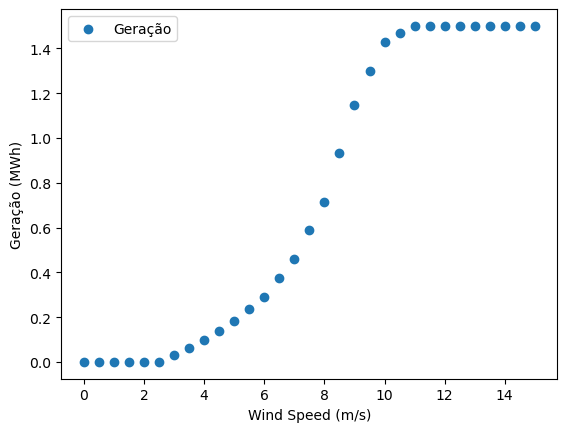

In [363]:
geracao_goldwind = (0, 0, 0, 0, 0, 0, 0.029, 0.063, 0.096, 0.140, 0.184, 0.238, 0.291, 0.376, 0.461, 0.588, 0.715, 
                    0.931, 1.147, 1.300, 1.428, 1.470, 1.500, 1.500, 1.500, 1.500, 1.500, 1.500, 1.500, 1.500, 1.500)

wind_goldwind = np.arange(0, 15.5, 0.5)

x = wind_goldwind
y = geracao_goldwind

plt.scatter(x, y, label='Geração')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Geração (MWh)')
plt.legend()

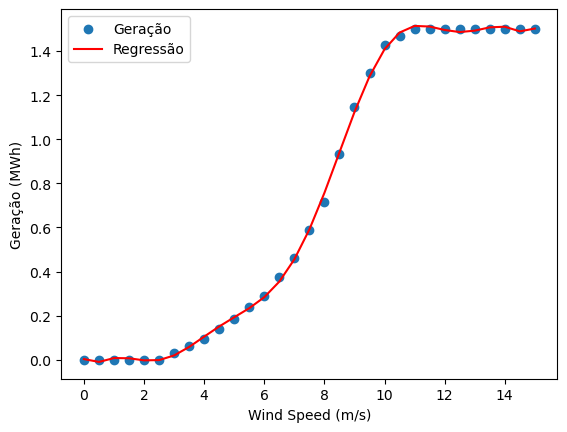

In [374]:
grau = 10

carac_reg = PolynomialFeatures(degree=grau)
x = x.reshape(-1, 1)
x_reg = carac_reg.fit_transform(x)

model_reg = LinearRegression()
model_reg.fit(x_reg, y)
y_reg = model_reg.predict(x_reg)

plt.scatter(x, y, label='Geração')
plt.plot(x, y_reg, color='red', label='Regressão')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Geração (MWh)')
plt.legend()

In [375]:
coeficientes = model_reg.coef_
termo_constante = model_reg.intercept_

# Exibindo a equação
equacao = f'Geração = {termo_constante:.8f} + '
for i, coeficiente in enumerate(coeficientes[1:]):
    equacao += f'{coeficiente:.20f} * x^{i+1} + '

print('\nEquação do modelo:')
print(equacao[:-2]) 


Equação do modelo:
Geração = 0.00277686 + -0.15349908306716864015 * x^1 + 0.42244441193971582482 * x^2 + -0.42538179576951234973 * x^3 + 0.21039896242360003886 * x^4 + -0.05776628138485342262 * x^5 + 0.00941804188455634336 * x^6 + -0.00093097436226311739 * x^7 + 0.00005468385686326027 * x^8 + -0.00000175491688182246 * x^9 + 0.00000002369496130280 * x^10 


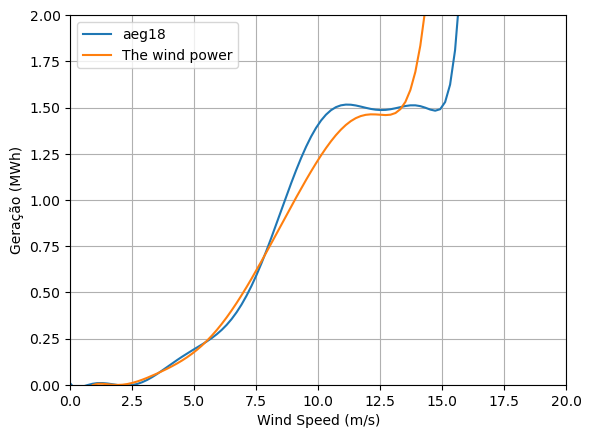

In [376]:
def aeg18(x):
    return (0.00277686 +
            -0.15349908306716864015 * x**1 +
            0.42244441193971582482 * x**2 +
            -0.42538179576951234973 * x**3 +
            0.21039896242360003886 * x**4 +
            -0.05776628138485342262 * x**5 +
            0.00941804188455634336 * x**6 +
            -0.00093097436226311739 * x**7 +
            0.00005468385686326027 * x**8 +
            -0.00000175491688182246 * x**9 +
            0.00000002369496130280 * x**10)

def the_wind_power(x):
    return (-0.39826470 +
            1.12204055891863974104 * x**1 +
            -1.22828550737722119734 * x**2 +
            0.69436437893823754752 * x**3 +
            -0.22818968172817086226 * x**4 +
            0.04670208517989218877 * x**5 +
            -0.00610575515790191987 * x**6 +
            0.00050963055538820283 * x**7 +
            -0.00002623439189743304 * x**8 +
            0.00000075646640774112 * x**9 +
            -0.00000000930294642830 * x**10)

# Gere valores de x para o gráfico
x_values = np.linspace(-100, 100, 1000)

# Avalie as funções para cada valor de x
y_values_1 = aeg18(x_values)
y_values_2 = the_wind_power(x_values)

# Plote o gráfico comparando as duas equações
plt.plot(x_values, y_values_1, label='aeg18')
plt.plot(x_values, y_values_2, label='The wind power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Geração (MWh)')
plt.xlim(0, 20)
plt.ylim(0, 2)
plt.legend()
plt.grid(True)

## Geração Eólica 2021

In [3]:
# Área da seção do rotor da turbina Gamesa G97
a_pindai = 7390

# Leitura do arquivo csv de tmy de vento da região de Pindaí
# Corrigir depois os dados anuais da NASA para o padrão TMY 
tmy_pindai = pd.read_csv("pindai_2021.csv")
# Excluindo valores faltantes
tmy_pindai = tmy_pindai.dropna()
# Inserindo a coluna de data no padrão correto
tmy_pindai = tmy_pindai.rename(columns ={'datetime': 'Data',
                                         'WS78M': 'Wind Speed'})
tmy_pindai['Data'] = pd.to_datetime(tmy_pindai['Data'])
# Aplicação da função de cálculo da eólica
gamesa, cp = calculo_eolica(a=a_pindai, w=list(tmy_pindai['Wind Speed']), usina='gamesa')
# Atribuição dos valores de geração calculados pela função para a coluna de geração do tmy
tmy_pindai["Geração"] = gamesa

tmy_pindai

,Data,Wind Speed,Geração
0,2021-01-01 00:00:00,8.344082,1.227394
1,2021-01-01 01:00:00,8.056355,1.118927
2,2021-01-01 02:00:00,7.459588,0.900090
3,2021-01-01 03:00:00,6.713629,0.650589
4,2021-01-01 04:00:00,6.415246,0.560981
...,...,...,...
8755,2021-12-31 19:00:00,4.113430,0.100668
8756,2021-12-31 20:00:00,4.763480,0.188833
8757,2021-12-31 21:00:00,5.445499,0.316445
8758,2021-12-31 22:00:00,6.127519,0.480805


In [4]:
# Criação de dicionário com o nome da usina e o número de aerogeradores utilizados
usinas_pindai = {
    'Pindai 2021': 8
    }

# Criação de dicionário para exportação dos valores das usinas
geracao_pindai = {}

# Loop para percorrer cada uma das usinas do dicionário dos aerogeradores
for usina, mult in usinas_pindai.items():
    # Criar uma cópia do tmy_pindai e atribuir a usina referente do dicionário de usinas
    globals()[usina] = tmy_pindai.copy()
    # Multiplicar a geração do aerogerador pelo numero de aerogeradores, a fim de obter a geração total do parque
    globals()[usina]['Geração'] = tmy_pindai['Geração'] * mult
    #globals()[usina] = globals()[usina][['Data', 'Wind Speed', 'Geração']]
    # Exportar cada uma das usinas para um csv nomeado de acordo com o nome descrito no dicionário
    globals()[usina].to_csv(f'{usina}.csv', index='False')

In [5]:
# Área da seção do rotor da turbina Enercon E92
a_enercon = 6648

# Leitura do arquivo csv de tmy de vento da região de Casa Nova
# Corrigir depois os dados anuais da NASA para o padrão TMY 
tmy_enercon = pd.read_csv("casa_nova_2021.csv")
# Excluindo valores faltantes
tmy_enercon = tmy_enercon.dropna()
# Excluindo colunas desnecessarias
tmy_enercon = tmy_enercon.rename(columns ={'datetime': 'Data',
                                         'WS78M': 'Wind Speed'})
tmy_enercon['Data'] = pd.to_datetime(tmy_enercon['Data'])

# Aplicação da função de cálculo da eólica
enercon, cp = calculo_eolica(a=a_enercon, w=list(tmy_enercon['Wind Speed']), usina='enercon')
# Atribuição dos valores de geração calculados pela função para a coluna de geração do tmy
tmy_enercon["Geração"] = enercon

tmy_enercon

,Data,Wind Speed,Geração
0,2021-01-01 00:00:00,9.026102,1.406176
1,2021-01-01 01:00:00,9.548273,1.624157
2,2021-01-01 02:00:00,9.537616,1.619795
3,2021-01-01 03:00:00,9.356455,1.544924
4,2021-01-01 04:00:00,8.589183,1.222842
...,...,...,...
8755,2021-12-31 19:00:00,4.614288,0.161838
8756,2021-12-31 20:00:00,4.827419,0.188786
8757,2021-12-31 21:00:00,5.019237,0.215212
8758,2021-12-31 22:00:00,4.838076,0.190199


In [6]:
# Criação de dicionário com o nome da usina e o número de aerogeradores utilizados
usinas_enercon = {
    'Casa Nova 2021': 14,
    }

# Criação de dicionário para exportação dos valores das usinas
geracao_pindai = {}

# Loop para percorrer cada uma das usinas do dicionário dos aerogeradores
for usina, mult in usinas_enercon.items():
    # Criar uma cópia do tmy_pindai e atribuir a usina referente do dicionário de usinas
    globals()[usina] = tmy_enercon.copy()
    # Multiplicar a geração do aerogerador pelo numero de aerogeradores, a fim de obter a geração total do parque
    globals()[usina]['Geração'] = tmy_enercon['Geração'] * mult
    #globals()[usina] = globals()[usina][['Data', 'Wind Speed', 'Geração']]
    # Exportar cada uma das usinas para um csv nomeado de acordo com o nome descrito no dicionário
    globals()[usina].to_csv(f'{usina}.csv', index='False')